# 探索神经网络学习率下降问题



在理想情况下，我们希望神经网络从错误中学习的速度越快越好。事实究竟是否如此？本文对其进行了研究和分析。本文主要作为博客[探索神经网络学习率下降问题](http://mrpanc.com/p/3203111967)的补充。

文本主要包括三部分，第一部分通过单个神经元的模型引入学习率下降问题，并对使用交叉熵代价函数的效果进行了验证。第二部分使用交叉熵代价函数识别MNIST数据集。第三部分使用Softmax识别MNIST数据集。

## 导入相关包

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from single_neural_network import Network
import improved_network as network2
import visualization as visual
import sys
sys.path.append("../module/")
import mnist_loader

# 使结果更易重复
random.seed(42)
np.random.seed(42)

## 问题引入

在理想情况下，我们希望神经网络从错误中学习的速度越快越好。那么究竟事实是否是这样呢？我们接下来通过一个小实验进行验证。假设现在要通过神经网络实现这样一个目标：输入$1$，输出$0$。为了简化实验过程，我们只用一个神经元进行训练。训练的神经元结构如下图所示。

<div align=center><img src="http://opqcor65w.bkt.clouddn.com/20180122235411_OaRamK_single_neural_network.jpeg" width="60%" /></div>

### 使用二次代价函数
训练时，我们使用二次代价函数以及Sigmoid激活函数。现在假设初始权值$w=0.6$，初始偏差$b=0.9$。代价函数值和输出值随`epoch`变化曲线如下图所示。观察曲线可知在权值和偏差是较为合适的值时，代价函数值的确下降的很快，学习的速度也很快。

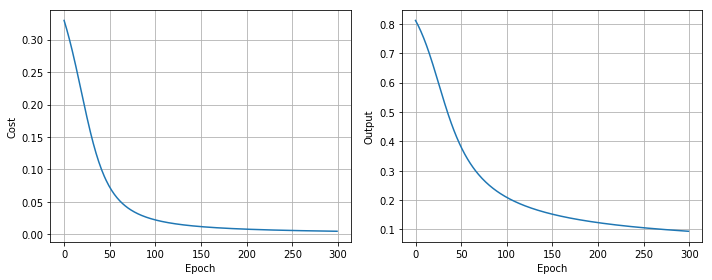

In [2]:
net = Network(0.6, 0.9)
training_cost, outputs = net.gradiant_decent((1, 0), 300, 0.15)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
visual.plot_training_cost(training_cost, axes[0])
visual.plot_output(outputs, axes[1])
plt.tight_layout()
plt.show()

接下来我们设置初始值$w=2$，初始偏差$b=2$。相比于之前设置的参数，现在初始的误差更大。运行结果可见下图。观察曲线可知在大约前150个`epoches`，代价函数下降的十分缓慢，学习曲线也十分平缓。这个现象表明初始误差变大之后，学习的速度反而变慢了。这与我们期望的效果截然相反。

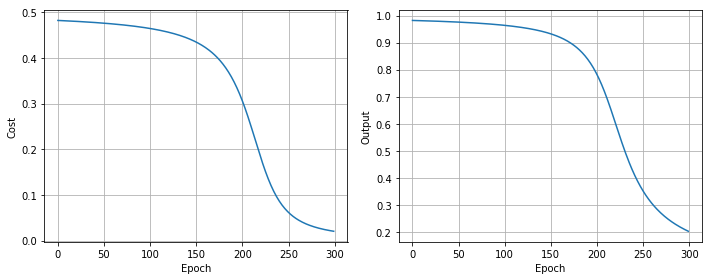

In [3]:
net = Network(2, 2)
training_cost, outputs = net.gradiant_decent((1, 0), 300, 0.15)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
visual.plot_training_cost(training_cost, axes[0])
visual.plot_output(outputs, axes[1])
plt.tight_layout()
plt.show()

出现上述现象的原因是在使用梯度下降的过程中，

$$
\begin{eqnarray}
\frac{\partial C}{\partial w} &=& (a-y)\sigma'(z)x, \\
\frac{\partial C}{\partial b} &=& (a-y)\sigma'(z),
\end{eqnarray}
$$

观察以上两个公式可知，学习率与$\sigma'(z)$相关，观察$\sigma(z)$和$\sigma'(z)$的图像，可以看到当神经网络训练的结果趋于$0$或是$1$时，$\sigma$函数曲线就会趋于平坦，$\sigma'(z)$变得很小，$\frac{\partial C}{\partial w}, \frac{\partial C}{\partial b}$也就随之变小，从而导致学习速度变慢。这就是学习率下降的原因所在。

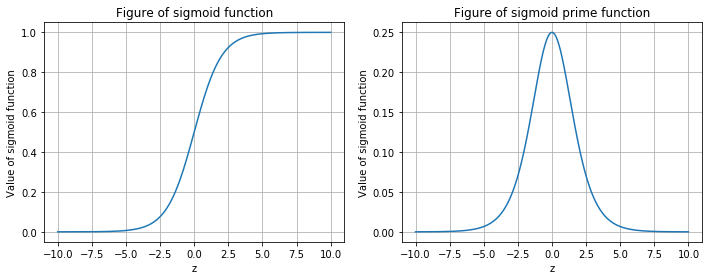

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
visual.plot_sigmoid(np.linspace(-10, 10, 1000), axes[0])
visual.plot_sigmoid_prime(np.linspace(-10, 10, 1000), axes[1])
plt.tight_layout()
plt.show()

### 使用交叉熵代价函数

这里罗列一下主要使用的几个公式，便于理解。

$$
\begin{eqnarray}
C(w, b) &=& -\frac{1}{n} \sum_x y\ln(a)+(1-y)\ln(1-a) \\
\frac{\partial C}{\partial w_j} &=& \frac{1}{n}\sum_x (a-y)x_j \\
\frac{\partial C}{\partial b_j} &=& \frac{1}{n}\sum_x(a-y) \\
\delta^L_j &=& a^L_j - y_j
\end{eqnarray}
$$

我们仍然使用上述模型进行训练，训练时，除了使用交叉熵代价函数替代二次代价函数之外，其他参数保持不变，即输入$x=1$，学习率$\alpha=0.15$，初始权值$w=0.6$，初始偏差$b=0.9$，预计输出$y=0$。观察下图可以发现与之前的结果一样，学习的效果很好。

In [5]:
class CrossEntropyCost(object):
    @staticmethod
    def fn(a, y):
        """返回损失"""
        return np.sum(np.nan_to_num(-y * np.log(a) - (1 - y) * np.log(1 - a)))

    @staticmethod
    def delta(z, a, y):
        """返回输出层的损失delta"""
        return a - y

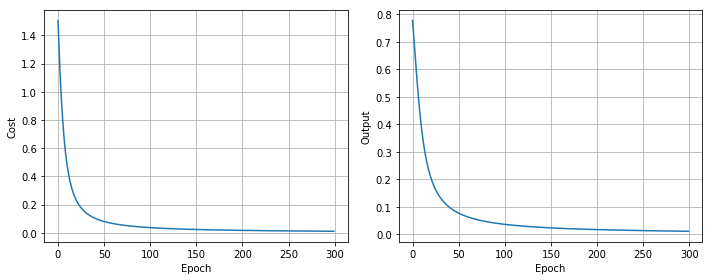

In [6]:
net = Network(0.6, 0.9, cost = CrossEntropyCost)
training_cost, outputs = net.gradiant_decent((1, 0), 300, 0.15)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
visual.plot_training_cost(training_cost, axes[0])
visual.plot_output(outputs, axes[1])
plt.tight_layout()
plt.show()

接下来设置初始权值为$w=2$，初始偏差$b=2$，重新进行实验。可以发现对比之前的学习效果，现在的学习速度和最终的学习效果都好了很多。这就是交叉熵代价函数给我们带来的惊喜。当初始的误差较大时，它可以防止学习速度被阻塞，让神经网络可以如我们期望的那样从误差中快速学习。

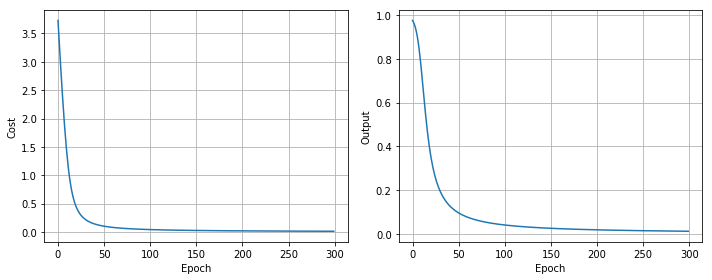

In [7]:
net = Network(2, 2, cost = CrossEntropyCost)
training_cost, outputs = net.gradiant_decent((1, 0), 300, 0.15)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
visual.plot_training_cost(training_cost, axes[0])
visual.plot_output(outputs, axes[1])
plt.tight_layout()
plt.show()

## 使用交叉熵代价函数识别MNIST数据集

训练时使用3层神经网络，网络隐藏层包含30个神经元，mini-batch的大小设置为10，学习率$\alpha$设置为0.5，并且训练30个epoches。最终的准确率到达了$95.54\%$（epoch 18），而使用二次代价函数时，最终的准确率为$95.29\%$，提升了$0.25\%$。

In [8]:
# Load data
training_data, test_data = mnist_loader.load_data_wrapper(dirpath="../data/mnist/")

In [9]:
%%time
net = network2.Network([784, 30, 10], cost=network2.CrossEntropyCost)
training_cost, training_accuracy, \
evaluation_cost, evaluation_accuracy = net.SGD(training_data, 30, 10, 0.5, \
                                               evaluation_data=test_data, \
                                               monitor_evaluation_accuracy=True)
print(np.max(evaluation_accuracy), np.argmax(evaluation_accuracy))

Epoch 0 training complete
Accuracy on evaluation data: 0.9201
Epoch 1 training complete
Accuracy on evaluation data: 0.9313
Epoch 2 training complete
Accuracy on evaluation data: 0.9433
Epoch 3 training complete
Accuracy on evaluation data: 0.9421
Epoch 4 training complete
Accuracy on evaluation data: 0.9514
Epoch 5 training complete
Accuracy on evaluation data: 0.9483
Epoch 6 training complete
Accuracy on evaluation data: 0.951
Epoch 7 training complete
Accuracy on evaluation data: 0.9497
Epoch 8 training complete
Accuracy on evaluation data: 0.9507
Epoch 9 training complete
Accuracy on evaluation data: 0.9507
Epoch 10 training complete
Accuracy on evaluation data: 0.9543
Epoch 11 training complete
Accuracy on evaluation data: 0.953
Epoch 12 training complete
Accuracy on evaluation data: 0.9545
Epoch 13 training complete
Accuracy on evaluation data: 0.9526
Epoch 14 training complete
Accuracy on evaluation data: 0.9528
Epoch 15 training complete
Accuracy on evaluation data: 0.9529
Epoc

将隐藏层神经元增加到50后，最终准确率到达了$96.55\%$（epoch 26），与使用二次代价函数时的准确率$96.02\%$相比，增加了$0.53\%$。虽然这样看来提升的并不多，但是换个角度来看，错误率从$3.98\%$降低到了$3.45\%$，错误率较之前降低了约$13\%$，还是十分可观的。

In [10]:
%%time
net = network2.Network([784, 50, 10], cost=network2.CrossEntropyCost)
training_cost, training_accuracy, \
evaluation_cost, evaluation_accuracy = net.SGD(training_data, 30, 10, 0.5, \
                                               evaluation_data=test_data, \
                                               monitor_evaluation_accuracy=True)
print(np.max(evaluation_accuracy), np.argmax(evaluation_accuracy))

Epoch 0 training complete
Accuracy on evaluation data: 0.9208
Epoch 1 training complete
Accuracy on evaluation data: 0.9419
Epoch 2 training complete
Accuracy on evaluation data: 0.9505
Epoch 3 training complete
Accuracy on evaluation data: 0.9514
Epoch 4 training complete
Accuracy on evaluation data: 0.9552
Epoch 5 training complete
Accuracy on evaluation data: 0.9508
Epoch 6 training complete
Accuracy on evaluation data: 0.9581
Epoch 7 training complete
Accuracy on evaluation data: 0.9567
Epoch 8 training complete
Accuracy on evaluation data: 0.9612
Epoch 9 training complete
Accuracy on evaluation data: 0.9579
Epoch 10 training complete
Accuracy on evaluation data: 0.9603
Epoch 11 training complete
Accuracy on evaluation data: 0.9587
Epoch 12 training complete
Accuracy on evaluation data: 0.9619
Epoch 13 training complete
Accuracy on evaluation data: 0.9615
Epoch 14 training complete
Accuracy on evaluation data: 0.9589
Epoch 15 training complete
Accuracy on evaluation data: 0.9615
Ep

当隐藏层神经元增加到100后，最终准确率到达了$97.14\%$，而使用二次代价函数的准确率只有$87.55\%$。

In [11]:
%%time
net = network2.Network([784, 100, 10], cost=network2.CrossEntropyCost)
training_cost, training_accuracy, \
evaluation_cost, evaluation_accuracy = net.SGD(training_data, 30, 10, 0.5, \
                                               evaluation_data=test_data, \
                                               monitor_evaluation_accuracy=True)
print(np.max(evaluation_accuracy), np.argmax(evaluation_accuracy))

Epoch 0 training complete
Accuracy on evaluation data: 0.9341
Epoch 1 training complete
Accuracy on evaluation data: 0.9482
Epoch 2 training complete
Accuracy on evaluation data: 0.9522
Epoch 3 training complete
Accuracy on evaluation data: 0.958
Epoch 4 training complete
Accuracy on evaluation data: 0.9615
Epoch 5 training complete
Accuracy on evaluation data: 0.9638
Epoch 6 training complete
Accuracy on evaluation data: 0.9607
Epoch 7 training complete
Accuracy on evaluation data: 0.9663
Epoch 8 training complete
Accuracy on evaluation data: 0.9669
Epoch 9 training complete
Accuracy on evaluation data: 0.9669
Epoch 10 training complete
Accuracy on evaluation data: 0.9688
Epoch 11 training complete
Accuracy on evaluation data: 0.9681
Epoch 12 training complete
Accuracy on evaluation data: 0.967
Epoch 13 training complete
Accuracy on evaluation data: 0.9691
Epoch 14 training complete
Accuracy on evaluation data: 0.9682
Epoch 15 training complete
Accuracy on evaluation data: 0.9697
Epoc

## Softmax
这里罗列一下Softmax的主要公式，便于理解：

$$
\begin{eqnarray}
a^L_j &=& \frac{e^{z^L_j}}{\sum_k e^{z^L_k}} \\
C &=& - \sum_k y_k\log a^L_k \\
\frac{\partial C}{\partial w^L_{jk}} &=& a_k^{L-1}(a_j^L - y_j) \\
\frac{\partial C}{\partial b^L_{j}} &=& a_j^L - y_j \\
\delta^L_j &=& a^L_j - y_j
\end{eqnarray}
$$

### 数值问题

In [12]:
def softmax(z):
    """传统的softmax"""
    return np.exp(z) / np.sum(np.exp(z), axis=0, keepdims=True)

当输入的$|z|$较小时，计算并无异常。

In [13]:
# 例1
z1 = [1, 1.2, 1.6, 1.9]
print(softmax(z1))

[ 0.15377223  0.18781783  0.28019128  0.37821866]


但是当输入的$|z|$较大时，会出现数值错误。出现数值错误的原因是由于浮点数只有64位，若$z$很大，计算$e^z$时会得到`inf`导致上溢出；若$z$很小，分母$\sum_ke^{z_k}=0$，导致下溢出。

In [14]:
# 例2
z2 = [1000, 1000, 1000, 10000]
z3 = [-1000, -1000, -1000, -10000]
print(softmax(z2), softmax(z3))

[ nan  nan  nan  nan] [ nan  nan  nan  nan]


/Users/pan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/pan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


那么应该如何解决呢？根据Softmax的参数冗余特性（证明见博客），我们可以让$z$减去一个$c$（$c=max(z)$）。经过处理之后，$max(z-c)=0$，意味着$e$的指数最大为0，解决了计算分子时出现的上溢出的问题；同时也保证了分母中必包含一项为$1$，从而保证分母不为$0$，解决了下溢出的问题。

In [15]:
def shift_softmax(z):
    """偏移C=max(z)，避免z过大或过小导致上溢出或下溢出"""
    c = np.max(z)
    exp_z = np.exp(z-c)
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

In [16]:
print(shift_softmax(z2), shift_softmax(z3))

[ 0.  0.  0.  1.] [ 0.33333333  0.33333333  0.33333333  0.        ]


观察上述代码得到的输出，我们可以发现经过Softmax函数计算后可能出现$a=0$的情况。当我们计算代价函数$C$时，需要计算$\log a$，这时就会出现$\log 0$的错误（。

In [17]:
def cost(a, y):
    return np.dot(np.log(a), np.transpose(y))

In [18]:
y = [0, 0, 0, 1]
print(cost(shift_softmax(z2), y))

nan


/Users/pan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


我们不再计算偏移$c$后的Softmax函数，而是直接计算偏移$c$后Softmax函数的$\log$值。直接计算$\log$值的好处在于消除了可能导致$\log 0$的项——求和项$\log \left(\sum_k e^{z^L_k-c}\right)$中至少有一项为$1$，使得求$\log$值时不会下溢出，避免了计算$\log 0$的悲剧发生。

$$
\begin{eqnarray}
\log a^L_j &=& \log \frac{e^{z^L_j-c}}{\sum_k e^{z^L_k-c}} \\
&=& \log e^{z^L_j-c} - \log \left(\sum_k e^{z^L_k-c}\right) \\
&=& \left(z^L_j-c\right)-\log \left(\sum_k e^{z^L_k-c}\right)
\end{eqnarray}
$$

In [19]:
def log_softmax(z):
    """根据公式直接求偏移后softmax的log值，避免出现求log0的情况"""
    shift_z = np.max(z)
    return z - shift_z - np.log(np.sum(np.exp(z-shift_z), axis=0, keepdims=True))
def cost2(log_a, y):
    """输入经过处理的log a"""
    return np.dot(log_a, np.transpose(y))

In [20]:
log_a = log_softmax(z2)
cost2(log_a, y)

0.0

### 用Softmax识别MNIST
参数与使用交叉熵代价函数时设置的一致，当隐藏层神经元为30时，准确率为$95.11\%$，比使用二次代价函数时的准确率$95.29\%$要低一些。

In [21]:
%%time
net = network2.Network([784, 30, 10], cost=network2.SoftmaxCost)
training_cost, training_accuracy, \
evaluation_cost, evaluation_accuracy = net.SGD(training_data, 30, 10, 0.5, \
                                               evaluation_data=test_data, \
                                               monitor_evaluation_accuracy=True)
print(np.max(evaluation_accuracy), np.argmax(evaluation_accuracy))

Epoch 0 training complete
Accuracy on evaluation data: 0.9022
Epoch 1 training complete
Accuracy on evaluation data: 0.9256
Epoch 2 training complete
Accuracy on evaluation data: 0.9334
Epoch 3 training complete
Accuracy on evaluation data: 0.9397
Epoch 4 training complete
Accuracy on evaluation data: 0.9411
Epoch 5 training complete
Accuracy on evaluation data: 0.942
Epoch 6 training complete
Accuracy on evaluation data: 0.946
Epoch 7 training complete
Accuracy on evaluation data: 0.9436
Epoch 8 training complete
Accuracy on evaluation data: 0.9465
Epoch 9 training complete
Accuracy on evaluation data: 0.9463
Epoch 10 training complete
Accuracy on evaluation data: 0.9503
Epoch 11 training complete
Accuracy on evaluation data: 0.9468
Epoch 12 training complete
Accuracy on evaluation data: 0.945
Epoch 13 training complete
Accuracy on evaluation data: 0.9488
Epoch 14 training complete
Accuracy on evaluation data: 0.9484
Epoch 15 training complete
Accuracy on evaluation data: 0.9457
Epoch

当隐藏层神经元增加到50时，准确率上升到$96.07\%$，比使用二次代价函数时的准确率$96.02\%$要高一些。

In [22]:
%%time
net = network2.Network([784, 50, 10], cost=network2.SoftmaxCost)
training_cost, training_accuracy, \
evaluation_cost, evaluation_accuracy = net.SGD(training_data, 30, 10, 0.5, \
                                               evaluation_data=test_data, \
                                               monitor_evaluation_accuracy=True)
print(np.max(evaluation_accuracy), np.argmax(evaluation_accuracy))

Epoch 0 training complete
Accuracy on evaluation data: 0.9228
Epoch 1 training complete
Accuracy on evaluation data: 0.9326
Epoch 2 training complete
Accuracy on evaluation data: 0.9381
Epoch 3 training complete
Accuracy on evaluation data: 0.9483
Epoch 4 training complete
Accuracy on evaluation data: 0.9487
Epoch 5 training complete
Accuracy on evaluation data: 0.9514
Epoch 6 training complete
Accuracy on evaluation data: 0.9465
Epoch 7 training complete
Accuracy on evaluation data: 0.952
Epoch 8 training complete
Accuracy on evaluation data: 0.9509
Epoch 9 training complete
Accuracy on evaluation data: 0.9524
Epoch 10 training complete
Accuracy on evaluation data: 0.9544
Epoch 11 training complete
Accuracy on evaluation data: 0.9539
Epoch 12 training complete
Accuracy on evaluation data: 0.9577
Epoch 13 training complete
Accuracy on evaluation data: 0.9544
Epoch 14 training complete
Accuracy on evaluation data: 0.9565
Epoch 15 training complete
Accuracy on evaluation data: 0.9555
Epo

当隐藏层神经元增加到100时，准确率上升到了$96.55\%$，高于二次代价函数达到的$87.55\%$准确率，但低于使用交叉熵代价函数达到的$97.14\%$准确率。

In [23]:
%%time
net = network2.Network([784, 100, 10], cost=network2.SoftmaxCost)
training_cost, training_accuracy, \
evaluation_cost, evaluation_accuracy = net.SGD(training_data, 30, 10, 0.5, \
                                               evaluation_data=test_data, \
                                               monitor_evaluation_accuracy=True)
print(np.max(evaluation_accuracy), np.argmax(evaluation_accuracy))

Epoch 0 training complete
Accuracy on evaluation data: 0.9221
Epoch 1 training complete
Accuracy on evaluation data: 0.9333
Epoch 2 training complete
Accuracy on evaluation data: 0.938
Epoch 3 training complete
Accuracy on evaluation data: 0.9485
Epoch 4 training complete
Accuracy on evaluation data: 0.9536
Epoch 5 training complete
Accuracy on evaluation data: 0.9546
Epoch 6 training complete
Accuracy on evaluation data: 0.9581
Epoch 7 training complete
Accuracy on evaluation data: 0.9605
Epoch 8 training complete
Accuracy on evaluation data: 0.9624
Epoch 9 training complete
Accuracy on evaluation data: 0.9627
Epoch 10 training complete
Accuracy on evaluation data: 0.96
Epoch 11 training complete
Accuracy on evaluation data: 0.9556
Epoch 12 training complete
Accuracy on evaluation data: 0.963
Epoch 13 training complete
Accuracy on evaluation data: 0.9639
Epoch 14 training complete
Accuracy on evaluation data: 0.963
Epoch 15 training complete
Accuracy on evaluation data: 0.9651
Epoch 1

> 若有不足之处或有疑问可以通过[博客留言](http://mrpanc.com/board/)或[邮件](mailto:mrpanc520@gmail.com)联系我。